In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/merged_dengue_dataset.csv')

In [5]:
# Preprocessing

# Drop unwanted columns
to_drop = [
    'post_cases',
    'pre_cases',
    'post_genome_count',
    'pre_genome_count',
    'post_genomes_per_1000',
    'pre_genomes_per_1000',
    'post_median_turnaround_days',
    'overall_median_turnaround_days',
    'treatment_Publicfrac_pred_high',
    'treatment_Publicfrac_pred_low',
    'risk_DCZ_pop_risk_upper',
    'risk_DCZ_pop_risk_lower',
    'risk_YF_pop_risk_upper',
    'risk_YF_pop_risk_lower',
    
]
df = df.drop(columns=to_drop)

# Encode categoricals
df['group_encoded'] = pd.factorize(df['group'])[0]
df['income_encoded'] = pd.factorize(df['income'])[0]

In [6]:
# Correlation Computation & Display

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlations against the target
corr_with_target = (
    numeric_df
    .corr()['pre_median_turnaround_days']
    .drop('pre_median_turnaround_days')
    .sort_values(key=lambda x: x.abs(), ascending=False)
)

# Print out the sorted correlations
print("Correlation with pre_median_turnaround_days:\n")
print(corr_with_target.to_string())

Correlation with pre_median_turnaround_days:

treatment_Publicfrac_pred         0.199147
risk_Total_population            -0.181563
gov_va                            0.179012
risk_DCZ_pop_risk_mean           -0.157723
gov_ge                            0.148650
gov_pv                            0.147468
risk_YF_pop_risk_mean            -0.141831
gov_rl                            0.129738
gov_rq                            0.118078
gov_cc                            0.114582
rd_value                          0.112471
risk_Surveillance_score           0.073607
gdp_gdp_usd_mean                  0.068198
gdp_gdp_ppp_mean                  0.040528
group_encoded                     0.020536
income_encoded                    0.020536
physicians_physicians_per_1000    0.014108


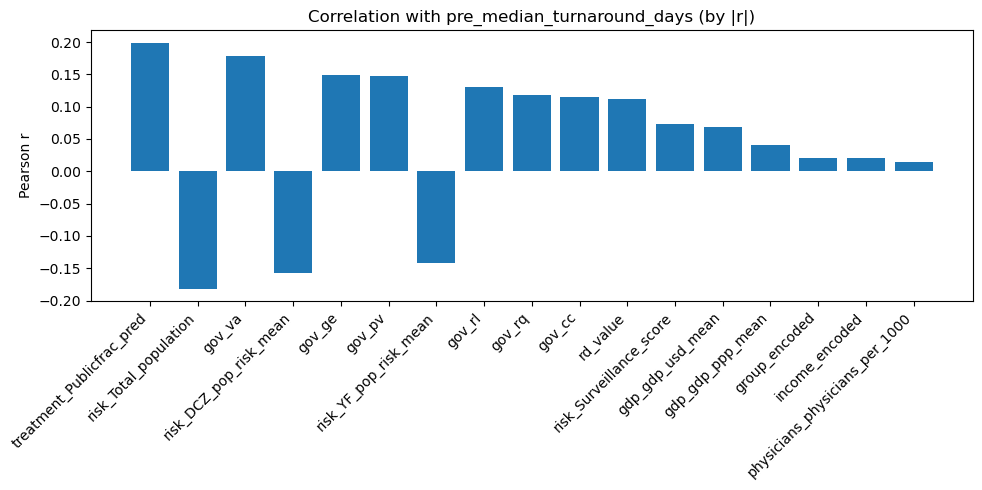

In [7]:
# Visualisation (ordered by absolute magnitude)

# Order variables by absolute correlation
sorted_vars = corr_with_target.abs().sort_values(ascending=False).index
sorted_corrs = corr_with_target[sorted_vars]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(sorted_vars, sorted_corrs)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Pearson r')
plt.title('Correlation with pre_median_turnaround_days (by |r|)')
plt.tight_layout()
plt.show()

In [47]:
# One hot encode 
# Copy & encode
df2 = df.copy()

# region dummies (drop_first=True avoids the dummy-trap)
region_dummies = pd.get_dummies(df2['group'], prefix='group', drop_first=True)

# income dummies
income_dummies = pd.get_dummies(df2['income'], prefix='income', drop_first=True)

df2 = pd.concat([df2, region_dummies, income_dummies], axis=1)

# Build numeric-only frame
num = df2.select_dtypes(include=[np.number])

# Compute corr with target
corr_with_target = (
    num
    .corr()['pre_median_turnaround_days']
    .drop('pre_median_turnaround_days')
    .sort_values(key=lambda x: x.abs(), ascending=False)
)

print(corr_with_target)

KeyError: 'post_median_turnaround_days'

In [8]:
# Univariate diagnostics

import os
from scipy.stats import linregress

In [9]:
# Make results folder
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

In [10]:
# Pick the top 6 correlated variables by absolute r
top_n = 6
top_vars = corr_with_target.abs().sort_values(ascending=False).head(top_n).index.tolist()

# Loop & plot
for var in top_vars:
    x = df[var]
    y = df['pre_median_turnaround_days']
    
    # fit simple linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.7)
    
    # regression line
    xs = np.array([x.min(), x.max()])
    ys = intercept + slope * xs
    plt.plot(xs, ys, '--', label=f'y={slope:.2f}x+{intercept:.2f}\n$r$={r_value:.2f}')
    
    plt.xlabel(var)
    plt.ylabel('pre_median_turnaround_days')
    plt.title(f'{var} vs. pre_median_turnaround_days')
    plt.legend()
    plt.tight_layout()
    
    # save
    out_path = os.path.join(results_dir, f'{var}_scatter.png')
    plt.savefig(out_path)
    plt.close()
    
    print(f'Saved plot for {var} → {out_path}')

Saved plot for treatment_Publicfrac_pred → results/treatment_Publicfrac_pred_scatter.png
Saved plot for risk_Total_population → results/risk_Total_population_scatter.png
Saved plot for gov_va → results/gov_va_scatter.png
Saved plot for risk_DCZ_pop_risk_mean → results/risk_DCZ_pop_risk_mean_scatter.png
Saved plot for gov_ge → results/gov_ge_scatter.png
Saved plot for gov_pv → results/gov_pv_scatter.png


In [12]:
# Univariate diagnostics & print/save with NaN‐filtering

import os
from scipy.stats import linregress

results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

metrics = []
top_n = 6
top_vars = corr_with_target.abs().sort_values(ascending=False).head(top_n).index.tolist()

for var in top_vars:
    x = df[var]
    y = df['pre_median_turnaround_days']
    
    # Drop missing 
    mask = x.notna() & y.notna()
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Fit regression 
    slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
    
    # Collect metrics 
    metrics.append({
        'variable':       var,
        'slope':          slope,
        'intercept':      intercept,
        'r_value':        r_value,
        'p_value':        p_value,
        'std_err (slope)': std_err
    })
    
    # — Plot and save —
    plt.figure(figsize=(6, 4))
    plt.scatter(x_clean, y_clean, alpha=0.7)
    xs = np.array([x_clean.min(), x_clean.max()])
    ys = intercept + slope * xs
    plt.plot(xs, ys, '--',
             label=f'y={slope:.2f}x+{intercept:.2f}\n$r$={r_value:.2f}')
    plt.xlabel(var)
    plt.ylabel('pre_median_turnaround_days')
    plt.title(f'{var} vs. pre_median_turnaround_days')
    plt.legend()
    plt.tight_layout()
    out_path = os.path.join(results_dir, f'{var}_scatter.png')
    plt.savefig(out_path)
    plt.close()
    print(f'Saved plot for {var} → {out_path}')

# Print the metrics table
import pandas as pd
metrics_df = pd.DataFrame(metrics)
print("\nUnivariate regression diagnostics:\n")
print(metrics_df.to_string(index=False))

Saved plot for treatment_Publicfrac_pred → results/treatment_Publicfrac_pred_scatter.png
Saved plot for risk_Total_population → results/risk_Total_population_scatter.png
Saved plot for gov_va → results/gov_va_scatter.png
Saved plot for risk_DCZ_pop_risk_mean → results/risk_DCZ_pop_risk_mean_scatter.png
Saved plot for gov_ge → results/gov_ge_scatter.png
Saved plot for gov_pv → results/gov_pv_scatter.png

Univariate regression diagnostics:

                 variable      slope   intercept   r_value  p_value  std_err (slope)
treatment_Publicfrac_pred 845.409557 1045.959219  0.199147 0.091199       493.716783
    risk_Total_population  -0.657528 1607.851190 -0.181563 0.138396         0.438366
                   gov_va 186.621430 1657.141751  0.179012 0.114449       116.885985
   risk_DCZ_pop_risk_mean  -0.747497 1603.236958 -0.157723 0.198945         0.576065
                   gov_ge 162.373942 1658.775532  0.148650 0.191062       123.099171
                   gov_pv 163.008703 1656.83749

In [13]:
# Univariate diagnostics with log‐transformed predictors

# Create log‐transformed columns
df['log_risk_Total_population']      = np.log1p(df['risk_Total_population'])
df['log_risk_DCZ_pop_risk_mean']     = np.log1p(df['risk_DCZ_pop_risk_mean'])

# Build a mapping from original → transformed names
transform_map = {
    'risk_Total_population':      'log_risk_Total_population',
    'risk_DCZ_pop_risk_mean':     'log_risk_DCZ_pop_risk_mean'
}

# Prepare diagnostics list: swap in the logs where appropriate
top_n   = 6
orig_top = corr_with_target.abs() \
                        .sort_values(ascending=False) \
                        .head(top_n) \
                        .index.tolist()
diag_vars = [ transform_map.get(v, v) for v in orig_top ]

# Run the loop
metrics = []
for var in diag_vars:
    x = df[var]
    y = df['pre_median_turnaround_days']
    
    # drop NaNs
    mask    = x.notna() & y.notna()
    x_clean = x[mask]
    y_clean = y[mask]
    
    # fit
    slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
    
    # collect
    metrics.append({
        'variable':       var,
        'slope':          slope,
        'intercept':      intercept,
        'r_value':        r_value,
        'p_value':        p_value,
        'std_err (slope)': std_err
    })
    
    # plot & save
    plt.figure(figsize=(6, 4))
    plt.scatter(x_clean, y_clean, alpha=0.7)
    xs = np.array([x_clean.min(), x_clean.max()])
    ys = intercept + slope * xs
    plt.plot(xs, ys, '--',
             label=f'y={slope:.2f}x+{intercept:.2f}\n$r$={r_value:.2f}')
    plt.xlabel(var)
    plt.ylabel('pre_median_turnaround_days')
    plt.title(f'{var} vs. pre_median_turnaround_days')
    plt.legend()
    plt.tight_layout()
    
    out_path = os.path.join(results_dir, f'{var}_scatter.png')
    plt.savefig(out_path)
    plt.close()
    print(f'Saved plot for {var} → {out_path}')

# Print metrics
metrics_df = pd.DataFrame(metrics)
print("\nUnivariate regression diagnostics (with transforms):\n")
print(metrics_df.to_string(index=False))

Saved plot for treatment_Publicfrac_pred → results/treatment_Publicfrac_pred_scatter.png
Saved plot for log_risk_Total_population → results/log_risk_Total_population_scatter.png
Saved plot for gov_va → results/gov_va_scatter.png
Saved plot for log_risk_DCZ_pop_risk_mean → results/log_risk_DCZ_pop_risk_mean_scatter.png
Saved plot for gov_ge → results/gov_ge_scatter.png
Saved plot for gov_pv → results/gov_pv_scatter.png

Univariate regression diagnostics (with transforms):

                  variable       slope   intercept   r_value  p_value  std_err (slope)
 treatment_Publicfrac_pred  845.409557 1045.959219  0.199147 0.091199       493.716783
 log_risk_Total_population -104.824340 1843.947999 -0.215582 0.077463        58.444587
                    gov_va  186.621430 1657.141751  0.179012 0.114449       116.885985
log_risk_DCZ_pop_risk_mean  -91.898275 1796.977129 -0.186421 0.127973        59.615622
                    gov_ge  162.373942 1658.775532  0.148650 0.191062       123.099171
 

In [14]:
# Multivariate OLS with transformed predictors

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [19]:
# Define your predictors & target
predictors = [
    'treatment_Publicfrac_pred',
    'gov_va',
    'gov_ge',
    'gov_pv',
    'log_risk_DCZ_pop_risk_mean'
]
target = 'pre_median_turnaround_days'

# Subset and clean
df_model = df[predictors + [target]].copy()

# Replace inf with NaN, then drop any rows with NaN
df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna()

# Build X and y
X = df_model[predictors]
X = sm.add_constant(X)    # adds intercept column
y = df_model[target]

                                OLS Regression Results                                
Dep. Variable:     pre_median_turnaround_days   R-squared:                       0.108
Model:                                    OLS   Adj. R-squared:                  0.014
Method:                         Least Squares   F-statistic:                     1.152
Date:                        Tue, 15 Jul 2025   Prob (F-statistic):              0.345
Time:                                18:46:02   Log-Likelihood:                -519.05
No. Observations:                          64   AIC:                             1052.
Df Residuals:                              57   BIC:                             1067.
Df Model:                                   6                                         
Covariance Type:                    nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

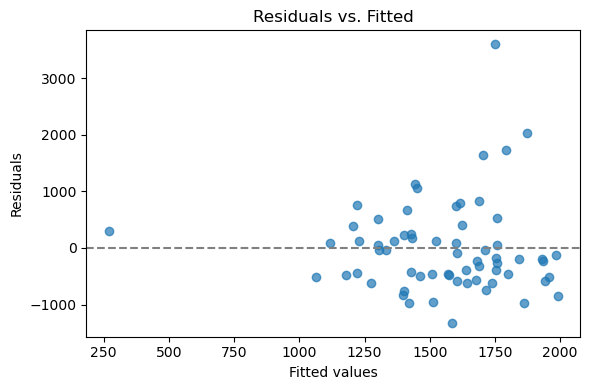

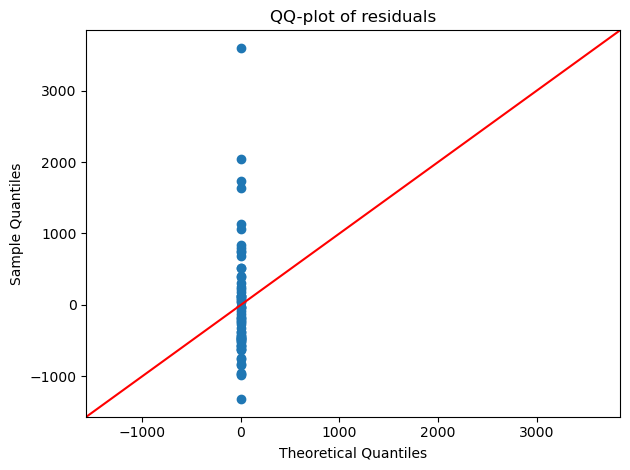

In [18]:
# Fit OLS
model = sm.OLS(y, X).fit()
print(model.summary())

# VIF check
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
})
print('\nVariance Inflation Factors:\n', vif_data)

# Residual diagnostics
resid  = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, alpha=0.7)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.tight_layout()
plt.show()

sm.qqplot(resid, line='45')
plt.title('QQ-plot of residuals')
plt.tight_layout()
plt.show()

In [22]:
# Missingness diagnostics
cols = [
    'pre_median_turnaround_days',
    'treatment_Publicfrac_pred',
    'gov_va',
    'gov_ge',
    'gov_pv',
    'log_risk_DCZ_pop_risk_mean'
]

# compute counts
stats = []
total = len(df)
for c in cols:
    # count NaN
    n_na  = df[c].isna().sum()
    # count infinite
    n_inf = df[c].isin([np.inf, -np.inf]).sum()
    stats.append({
        'column':      c,
        'n_missing':   n_na,
        'n_infinite':  n_inf,
        'n_valid':     total - n_na - n_inf
    })

miss_df = pd.DataFrame(stats)
print(miss_df.to_string(index=False))


                    column  n_missing  n_infinite  n_valid
pre_median_turnaround_days          5           0       82
 treatment_Publicfrac_pred         11           0       76
                    gov_va          3           0       84
                    gov_ge          3           0       84
                    gov_pv          3           0       84
log_risk_DCZ_pop_risk_mean         15           0       72


In [20]:
# X and y have been cleaned already
X = sm.add_constant(df_model[predictors])
y = df_model['pre_median_turnaround_days']

glm = sm.GLM(y, X, family=sm.families.Gaussian())
res_glm = glm.fit()
print(res_glm.summary())

# extract the log‐likelihood and σ̂
print("Log‐likelihood:", res_glm.llf)
print("σ̂  (scale):  ", np.sqrt(res_glm.scale))

                     Generalized Linear Model Regression Results                      
Dep. Variable:     pre_median_turnaround_days   No. Observations:                   64
Model:                                    GLM   Df Residuals:                       58
Model Family:                        Gaussian   Df Model:                            5
Link Function:                       Identity   Scale:                      7.4005e+05
Method:                                  IRLS   Log-Likelihood:                -520.12
Date:                        Tue, 15 Jul 2025   Deviance:                   4.2923e+07
Time:                                18:51:56   Pearson chi2:                 4.29e+07
No. Iterations:                             3   Pseudo R-squ. (CS):            0.07778
Covariance Type:                    nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [26]:
# Random Forest Regression & Feature Importances

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Define predictors & target
predictors = [
    'treatment_Publicfrac_pred',
    'gov_va',
    'gov_ge',
    'gov_pv',
    'log_risk_Total_population',
    'log_risk_DCZ_pop_risk_mean'
]
target = 'pre_median_turnaround_days'

# 2) Build & clean the RF dataset
df_rf = df[predictors + [target]] \
    .replace([np.inf, -np.inf], np.nan) \
    .dropna()

X = df_rf[predictors]
y = df_rf[target]

# 3) Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Train  R²: 0.842
Test   R²: -0.159
Test  RMSE: 1483.25

5‐fold CV R²: -0.599 ± 0.829

5‐fold CV R²: -0.599 ± 0.829

Feature importances:
 gov_pv                        0.284383
gov_va                        0.242157
log_risk_Total_population     0.160921
treatment_Publicfrac_pred     0.128807
gov_ge                        0.093914
log_risk_DCZ_pop_risk_mean    0.089818 



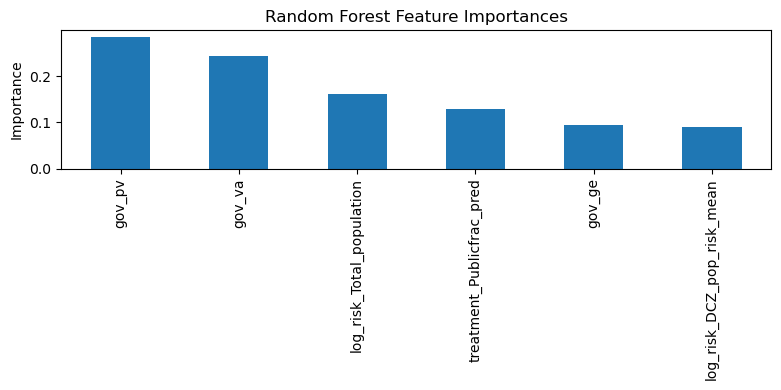

In [28]:
# 4) Initialise and fit the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 5) Evaluate on train & test
# Train / Test R²  
print(f"Train  R²: {rf.score(X_train, y_train):.3f}")
print(f"Test   R²: {r2_score(y_test, y_pred):.3f}")

# Test RMSE (compute MSE then sqrt)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Test  RMSE: {rmse:.2f}\n")

# 5‐fold CV R² remains the same
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print(f"5‐fold CV R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}\n")

# 6) Cross‐validated R²
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print(f"5‐fold CV R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}\n")

# 7) Feature importances
feat_imp = pd.Series(rf.feature_importances_, index=predictors) \
             .sort_values(ascending=False)
print("Feature importances:\n", feat_imp.to_string(), "\n")

# 8) Plot importances
plt.figure(figsize=(8, 4))
feat_imp.plot(kind='bar')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

In [38]:
# PCA + K-Means Clustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Define features: numeric + categorical
target = 'pre_median_turnaround_days'
numeric_features = [
    'treatment_Publicfrac_pred',
    'gov_va',
    'gov_ge',
    'gov_pv',
    'log_risk_Total_population',
    'log_risk_DCZ_pop_risk_mean'
]
categorical_features = ['group', 'income']

# Subset and drop any NaN/Inf rows
cols = numeric_features + categorical_features + [target]
df_clust = (
    df[cols]
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .reset_index(drop=True)
)

# 2) Encode categoricals
X_num = df_clust[numeric_features]
X_cat = pd.get_dummies(df_clust[categorical_features], drop_first=False)
df_clust = pd.concat([df_clust, X_cat], axis=1)
X = pd.concat([X_num, X_cat], axis=1)

# 3) Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
# 4) PCA to 2D for visualisation
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 5) K-Means clustering into 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Attach results to df_clust
df_clust['cluster'] = clusters
df_clust['PC1'] = X_pca[:, 0]
df_clust['PC2'] = X_pca[:, 1]

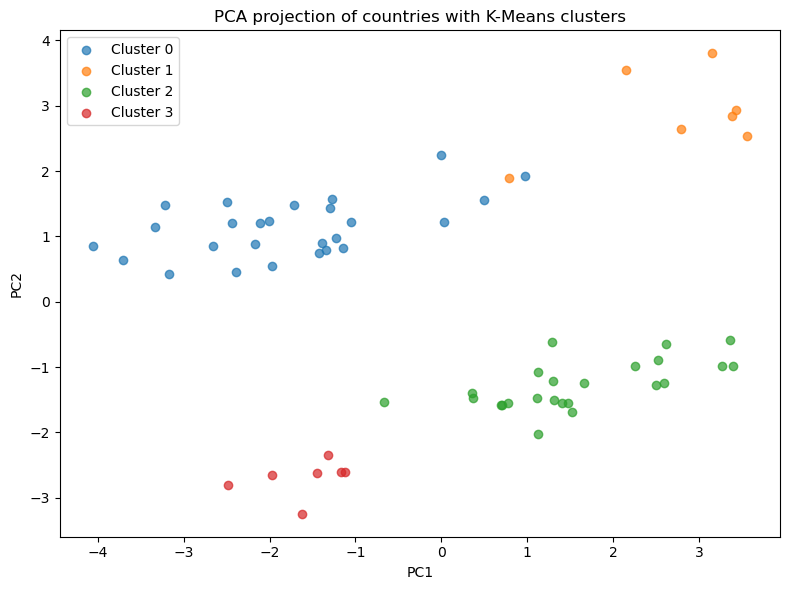

/var/folders/nw/jnrc_9qd2kv15xjq83h1yqh80000gn/T/ipykernel_11187/2515622403.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cluster_groups, labels=[f'Cluster {c}' for c in sorted(df_clust['cluster'].unique())])


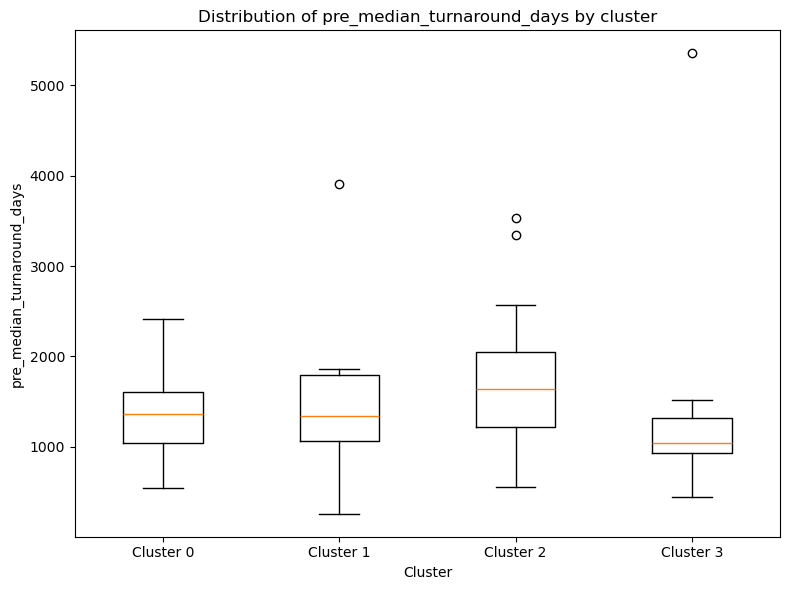

In [41]:
# Scatter of PC1 vs PC2 colored by cluster
plt.figure(figsize=(8, 6))
for c in sorted(df_clust['cluster'].unique()):
    mask = df_clust['cluster'] == c
    plt.scatter(
        df_clust.loc[mask, 'PC1'],
        df_clust.loc[mask, 'PC2'],
        label=f'Cluster {c}',
        alpha=0.7
    )
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection of countries with K-Means clusters')
plt.tight_layout()
plt.show()

# Boxplot of turnaround time by cluster
cluster_groups = [
    df_clust[df_clust['cluster'] == c][target]
    for c in sorted(df_clust['cluster'].unique())
]
plt.figure(figsize=(8, 6))
plt.boxplot(cluster_groups, labels=[f'Cluster {c}' for c in sorted(df_clust['cluster'].unique())])
plt.xlabel('Cluster')
plt.ylabel(target)
plt.title('Distribution of pre_median_turnaround_days by cluster')
plt.tight_layout()
plt.show()

In [42]:
# Diagnostics of what defines the clusters

# 1) Cluster sizes
print("Cluster sizes:")
print(df_clust['cluster'].value_counts().sort_index(), "\n")

# 2) Raw feature means by cluster
print("Mean of numeric + dummy features by cluster:")
cluster_means = df_clust.groupby('cluster')[
    numeric_features + list(X_cat.columns)
].mean()
print(cluster_means, "\n")

# 3) Centroids in original units (for numeric only)
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids_unscaled = pd.DataFrame(
    scaler.inverse_transform(centroids_scaled),
    columns=X.columns
)
print("Centroids (unscaled) for numeric features:")
print(centroids_unscaled[numeric_features], "\n")

# 4) Which numeric features vary most across clusters?
var_across = centroids_unscaled[numeric_features].var().sort_values(ascending=False)
print("Variance of centroids across clusters (numeric features):")
print(var_across, "\n")

# 5) PCA loadings for PC1 and PC2??
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=['PC1', 'PC2']
)
print("PCA loadings (relation of features to PC1/PC2):")
print(loadings)

Cluster sizes:
cluster
0    26
1     7
2    24
3     7
Name: count, dtype: int64 

Mean of numeric + dummy features by cluster:
         treatment_Publicfrac_pred    gov_va    gov_ge    gov_pv  \
cluster                                                            
0                         0.579329 -0.345467 -0.589258 -0.519890   
1                         0.656456  0.270000  0.755408  0.680510   
2                         0.735463 -0.059077 -0.156726  0.025982   
3                         0.777258 -0.797041 -0.937653 -1.111122   

         log_risk_Total_population  log_risk_DCZ_pop_risk_mean  group_HIC  \
cluster                                                                     
0                         3.045159                    2.990180        0.0   
1                         1.769814                    1.689511        1.0   
2                         2.504900                    2.397280        0.0   
3                         3.121600                    3.008280        0.0   



Countries per cluster:
cluster
0    26
1     7
2    24
3     7
Name: count, dtype: int64 

Cluster × Region (counts):
 group    HIC  LIC  LMC  UMC
cluster                    
0          0    0   26    0
1          7    0    0    0
2          0    0    0   24
3          0    7    0    0 

Cluster × Region (proportions):
 group    HIC  LIC  LMC  UMC
cluster                    
0        0.0  0.0  1.0  0.0
1        1.0  0.0  0.0  0.0
2        0.0  0.0  0.0  1.0
3        0.0  1.0  0.0  0.0 

Cluster × Income (counts):
 income   High income  Low income  Lower middle income  Upper middle income
cluster                                                                   
0                  0           0                   26                    0
1                  7           0                    0                    0
2                  0           0                    0                   24
3                  0           7                    0                    0 

Cluster × Income (proportion

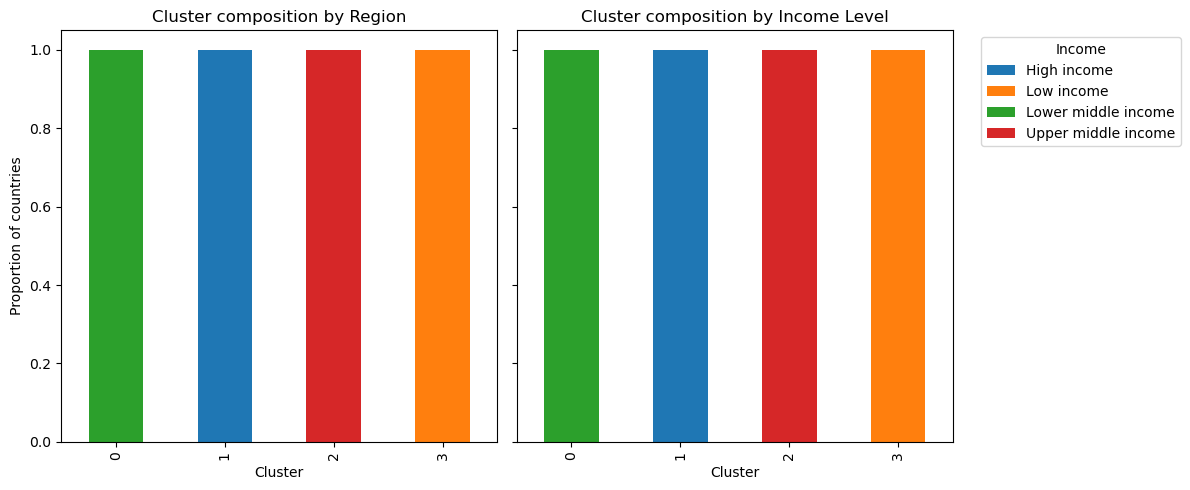

In [43]:
# Examine cluster composition by region (group) and income level

# 1) Count of countries per cluster
print("Countries per cluster:")
print(df_clust['cluster'].value_counts().sort_index(), "\n")

# 2) Crosstab: clusters vs. region (group)
ct_group = pd.crosstab(df_clust['cluster'], df_clust['group'])
print("Cluster × Region (counts):\n", ct_group, "\n")

# 3) Crosstab normalized by cluster (proportions)
ct_group_prop = ct_group.div(ct_group.sum(axis=1), axis=0)
print("Cluster × Region (proportions):\n", ct_group_prop.round(2), "\n")

# 4) Crosstab: clusters vs. income level
ct_income = pd.crosstab(df_clust['cluster'], df_clust['income'])
print("Cluster × Income (counts):\n", ct_income, "\n")

# 5) Crosstab normalised by cluster (proportions)
ct_income_prop = ct_income.div(ct_income.sum(axis=1), axis=0)
print("Cluster × Income (proportions):\n", ct_income_prop.round(2), "\n")

# 6) Visualise with stacked bar charts
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Region composition
ct_group_prop.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[0], 
    legend=False
)
axes[0].set_title('Cluster composition by Region')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Proportion of countries')

# Income composition
ct_income_prop.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[1]
)
axes[1].set_title('Cluster composition by Income Level')
axes[1].set_xlabel('Cluster')
axes[1].legend(title='Income', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Segment centroids (in original units):
   treatment_Publicfrac_pred    gov_va    gov_ge    gov_pv  \
0                   0.726081 -0.675051 -0.716939 -0.548367   
1                   0.812881  0.515223  0.047902  0.705223   
2                   0.363235 -0.666429 -0.547698 -1.239603   
3                   0.558562  0.233312  0.352662 -0.061883   

   log_risk_Total_population  log_risk_DCZ_pop_risk_mean  \
0                   2.632521                    2.545727   
1                   0.549340                    0.507161   
2                   5.365748                    5.222256   
3                   3.885442                    3.797155   

   pre_median_turnaround_days  
0                 1657.625000  
1                 1840.406250  
2                  922.555556  
3                 1376.454545  


<Figure size 600x400 with 0 Axes>

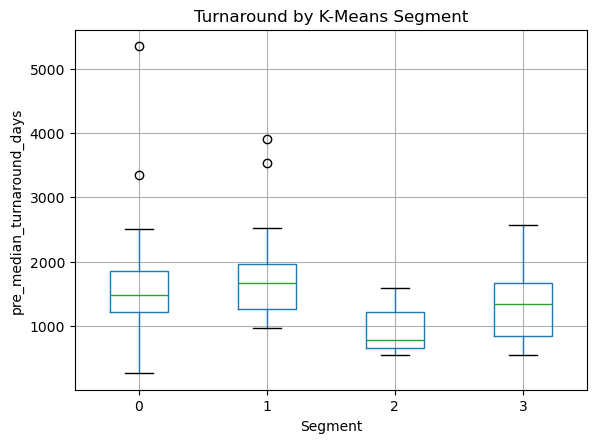

In [44]:
# K-Means on X + y

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) Build & clean
predictors = [
    'treatment_Publicfrac_pred',
    'gov_va',
    'gov_ge',
    'gov_pv',
    'log_risk_Total_population',
    'log_risk_DCZ_pop_risk_mean'
]
target = 'pre_median_turnaround_days'

df_seg = (
    df[predictors + [target]]
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .reset_index(drop=True)
)

# 2) Scale everything (so y counts equally)
scaler = StandardScaler()
XY = scaler.fit_transform(df_seg[predictors + [target]])

# 3) Cluster into 4 segments
km = KMeans(n_clusters=4, random_state=42)
df_seg['segment_km'] = km.fit_predict(XY)

# 4) Inspect segment means (unscaled)
seg_centroids = pd.DataFrame(
    scaler.inverse_transform(km.cluster_centers_),
    columns=predictors + [target]
)
print("Segment centroids (in original units):")
print(seg_centroids)

# 5) Turnaround distribution by segment
plt.figure(figsize=(6,4))
df_seg.boxplot(column=target, by='segment_km')
plt.suptitle('')
plt.title('Turnaround by K-Means Segment')
plt.ylabel(target)
plt.xlabel('Segment')
plt.show()

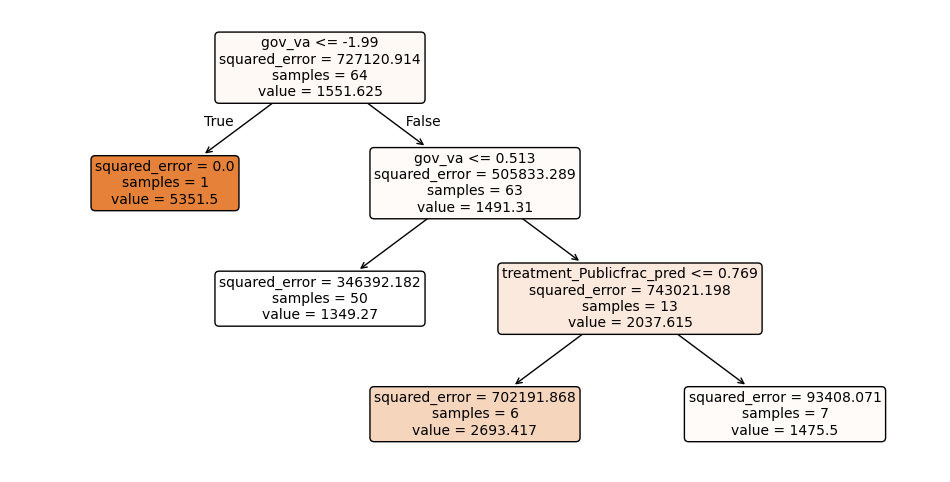


Mean turnaround days by tree segment:
segment_tree
1    5351.500000
3    1349.270000
5    2693.416667
6    1475.500000
Name: pre_median_turnaround_days, dtype: float64

Feature means by tree segment:
              treatment_Publicfrac_pred    gov_va    gov_ge    gov_pv  \
segment_tree                                                            
1                              0.925909 -2.108571 -1.665714 -0.808571   
3                              0.633280 -0.441986 -0.422900 -0.486286   
5                              0.648324  0.794167  0.417381  0.484881   
6                              0.895687  0.764796 -0.007347  0.900816   

              log_risk_Total_population  log_risk_DCZ_pop_risk_mean  
segment_tree                                                         
1                              1.957415                    1.936581  
3                              3.108998                    3.014407  
5                              2.181821                    2.126002  
6         

In [45]:
# Regression-tree segmentation

from sklearn.tree import DecisionTreeRegressor, plot_tree

# 1) Clean data
df_tree = (
    df[predictors + [target]]
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .reset_index(drop=True)
)
X = df_tree[predictors]
y = df_tree[target]

# 2) Fit a small tree (e.g. max 4 leaves)
tree = DecisionTreeRegressor(max_leaf_nodes=4, random_state=42)
tree.fit(X, y)

# 3) Assign each country to its leaf
df_tree['segment_tree'] = tree.apply(X)

# 4) Plot the tree structure
plt.figure(figsize=(12,6))
plot_tree(
    tree,
    feature_names=predictors,
    rounded=True,
    filled=True,
    fontsize=10
)
plt.show()

# 5) Leaf (segment) summaries
print("\nMean turnaround days by tree segment:")
print(df_tree.groupby('segment_tree')[target].mean())

print("\nFeature means by tree segment:")
print(df_tree.groupby('segment_tree')[predictors].mean())

## Testing Number of Clusters

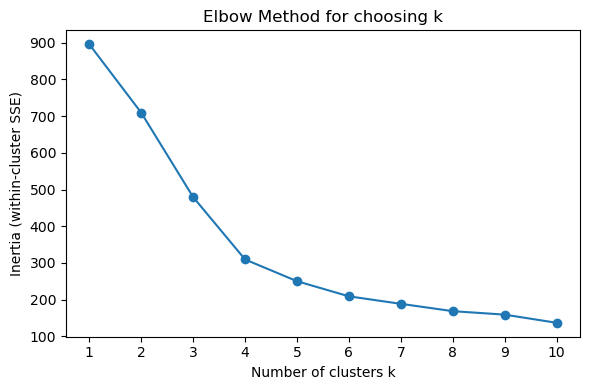

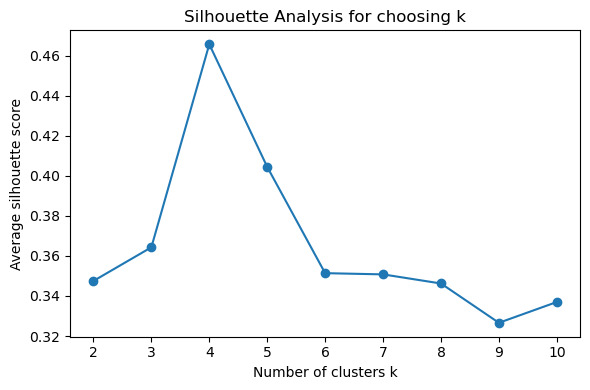

In [37]:
# Testing cluster numbers 

# 1) Try K = 1…10
inertias = []
K_range  = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertias.append(km.inertia_)

# 2) Plot
plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (within-cluster SSE)')
plt.title('Elbow Method for choosing k')
plt.xticks(K_range)
plt.tight_layout()
plt.show()

from sklearn.metrics import silhouette_score

sil_scores = []
K_range = range(2, 11)   # silhouette undefined at k=1
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Average silhouette score')
plt.title('Silhouette Analysis for choosing k')
plt.xticks(K_range)
plt.tight_layout()
plt.show()